# Seismic Risk Analysis for Major Asian Cities

See METHODOLOGY.md for details.


In [1]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Geospatial
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import folium
from folium import plugins

# Progress bars
# progress tracking

# Import our custom modules
import sys
sys.path.append('../src')

from earthquake_exposure import (
    api,
    acquire, 
    preprocess,
    spatial_index,
    metrics,
    viz
)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print(" All libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

 All libraries imported successfully
Analysis Date: 2026-01-11 11:44


In [2]:
# Analysis parameters
CONFIG = {
    'start_date': '2025-01-01',
    'end_date': '2025-12-31',
    'min_magnitude': 5.0,
    'min_population': 250000,
    'search_radius_km': 500.0,
'target_crs': 'EPSG:4087' # World Equidistant Cylindrical
}

# Date range for 2025
start_date = datetime(2025, 1, 1)
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)

print("ANALYSIS CONFIGURATION")
for key, value in CONFIG.items():
    print(f"{key}: {value}")
print(f"{'start_date'}: {start_date.date()}")
print(f"{'end_date'}: {end_date.date()}")


ANALYSIS CONFIGURATION
start_date: 2025-01-01
end_date: 2025-12-31
min_magnitude: 5.0
min_population: 250000
search_radius_km: 500.0
target_crs: EPSG:4087
start_date: 2025-01-01
end_date: 2025-12-31


## 1. Data Acquisition

### 1.1 Fetch Earthquake Data from USGS

We use the USGS Earthquake Catalog API to fetch all earthquakes with magnitude ≥ 5.0 in the year 2025.

Note: We extract the earthquake **depth** from the GeoJSON geometry coordinates, as this is essential for accurate PGA calculations.

In [3]:
print("Fetching earthquake data from USGS API...")
print(f"Time range: {start_date.date()} to {end_date.date()}")
print(f"Minimum magnitude: {CONFIG['min_magnitude']}")

# Fetch data using our API module
earthquakes_raw = acquire.get_earthquake_data(
    start_date=CONFIG['start_date'], end_date=CONFIG['end_date'],
    min_mag=CONFIG['min_magnitude']
)

print(f"\n Fetched {len(earthquakes_raw)} earthquakes")

# Display sample
display(earthquakes_raw.head())

# Basic statistics
if not earthquakes_raw.empty:
    print("\nEarthquake Statistics:")
print(f"Magnitude range: {earthquakes_raw['mag'].min():.1f} - {earthquakes_raw['mag'].max():.1f}")
print(f"Depth range: {earthquakes_raw['depth_km'].min():.1f} - {earthquakes_raw['depth_km'].max():.1f} km")
print(f"Mean depth: {earthquakes_raw['depth_km'].mean():.1f} km")

Fetching earthquake data from USGS API...
Time range: 2025-01-01 to 2025-12-31
Minimum magnitude: 5.0

 Fetched 1263 earthquakes


,geometry,mag,place,time,updated,tz,url,detail,felt,cdi,...,sources,types,nst,dmin,rms,gap,magType,type,title,depth_km
0,POINT Z (155.273 -7.0134 10),5.1,"80 km SSW of Panguna, Papua New Guinea",1767093728302,1767094659040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",us,",",origin,phase-data,",38,4.176,0.80,70.0,mb,earthquake,"M 5.1 - 80 km SSW of Panguna, Papua New Guinea",10.000
1,POINT Z (128.7445 27.5468 10),5.5,"20 km NNE of Wadomari, Japan",1767082344533,1767170281940,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,8.0,3.8,...,",us,usauto,",",dyfi,ground-failure,internal-moment-tensor,lo...",80,0.823,0.85,36.0,mww,earthquake,"M 5.5 - 20 km NNE of Wadomari, Japan",10.000
2,POINT Z (152.4689 -5.3688 10),5.1,"115 km S of Kokopo, Papua New Guinea",1767008402089,1767009463040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",us,",",origin,phase-data,",58,1.209,1.01,124.0,mb,earthquake,"M 5.1 - 115 km S of Kokopo, Papua New Guinea",10.000
3,POINT Z (141.9521 29.7455 46.141),5.1,"Izu Islands, Japan region",1766857477048,1766963186892,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,2.0,...,",us,",",dyfi,origin,phase-data,",45,2.648,1.29,103.0,mb,earthquake,"M 5.1 - Izu Islands, Japan region",46.141
4,POINT Z (122.0406 24.6574 67.534),6.6,"31 km ESE of Yilan, Taiwan",1766847956364,1768037149356,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,438.0,5.6,...,",pt,at,us,usauto,",",dyfi,ground-failure,impact-link,internal-mome...",80,0.586,0.92,25.0,mww,earthquake,"M 6.6 - 31 km ESE of Yilan, Taiwan",67.534



Earthquake Statistics:
Magnitude range: 5.0 - 8.8
Depth range: 3.0 - 609.2 km
Mean depth: 38.8 km


### 1.2 Load City Data from Natural Earth

We filter for Asian cities with population ≥ 250,000 to focus on major urban centers.

In [4]:
print(" Loading city data from Natural Earth...")

# Load cities using our acquire module
cities_raw = acquire.load_asian_cities(
    min_population=CONFIG['min_population']
)

print(f"Loaded {len(cities_raw)} cities")

# Display sample
display(cities_raw.head())

# Geographic distribution
print("\nCities by Country (Top 10):")
country_counts = cities_raw['country'].value_counts().head(10)
for country, count in country_counts.items():
    print(f"{country}: {count} cities")

 Loading city data from Natural Earth...
Loaded 1721 cities


,scalerank,natscale,labelrank,name,namepar,namealt,diffascii,nameascii,adm0cap,capalt,...,pop_other,rank_max,rank_min,geonameid,meganame,ls_name,ls_match,checkme,featureclass,geometry
7,10,1,5,Sakarya,None,None,0,Sakarya,0,0,...,0,10,10,752850,None,None,0,0,Admin-1 capital,POINT (30.4 40.76666)
25,10,1,2,Umuahia,None,None,0,Umuahia,0,0,...,0,10,10,2320576,None,None,0,0,Admin-1 capital,POINT (7.486 5.532)
26,10,1,2,Uyo,None,None,0,Uyo,0,0,...,0,11,10,2319480,None,None,0,0,Admin-1 capital,POINT (7.85 5.008)
29,10,1,6,Shah Alam,None,None,0,Shah Alam,0,0,...,0,10,10,1732903,None,None,0,0,Admin-1 capital,POINT (101.55 3.0667)
33,10,1,3,Zagazig,None,None,0,Zagazig,0,0,...,0,10,10,359493,None,None,0,0,Admin-1 capital,POINT (31.51666 30.58333)



Cities by Country (Top 10):
China: 243 cities
United States of America: 154 cities
India: 143 cities
Brazil: 78 cities
Russia: 75 cities
Mexico: 49 cities
Japan: 47 cities
Indonesia: 43 cities
Nigeria: 37 cities
Turkey: 31 cities


## 2. Data Preprocessing

### 2.1 Coordinate System Projection

We project both datasets to **EPSG:4087 (World Equidistant Cylindrical)** for accurate distance calculations in kilometers.

Why: Geographic coordinates (lat/lon) measure angles, not distances. We need a metric projection where 1 unit = 1 meter.

In [5]:
print("Projecting to metric coordinate system (EPSG:4087)...")

# Project earthquakes
earthquakes = preprocess.project_to_metric(
    earthquakes_raw, 
    target_crs=CONFIG['target_crs']
)

# Project cities
cities = preprocess.project_to_metric(
    cities_raw,
    target_crs=CONFIG['target_crs']
)

print(f"Earthquakes projected: {earthquakes.crs}")
print(f"Cities projected: {cities.crs}")

# Clean data
earthquakes_clean = preprocess.clean_earthquake_data(earthquakes)
print(f"Removed {len(earthquakes) - len(earthquakes_clean)} invalid earthquake records")

earthquakes = earthquakes_clean

Projecting to metric coordinate system (EPSG:4087)...
Earthquakes projected: EPSG:4087
Cities projected: EPSG:4087
Removed 0 invalid earthquake records


### 2.2 Build Spatial Index (KD-Tree)

To efficiently find earthquakes near each city, we build a **KD-Tree spatial index**.

Performance:
- Nested loops: O(n × m) = O(n²) → ~400,000 comparisons for 500 cities × 150 quakes
- KD-Tree: O(n log m) → ~3,500 operations

This makes the analysis much faster.

In [6]:
print("Building KD-Tree spatial index...")

# Build tree using our spatial_index module
kdtree, eq_coords = spatial_index.build_kdtree(earthquakes)

print(f"KD-Tree built with {len(eq_coords)} earthquake locations")
print(f"Tree depth: ~{int(np.log2(len(eq_coords)))} levels")
print(f"Query complexity: O(log n) = O({int(np.log2(len(eq_coords)))})")

Building KD-Tree spatial index...
KD-Tree built with 1263 earthquake locations
Tree depth: ~10 levels
Query complexity: O(log n) = O(10)


## 3. Peak Ground Acceleration (PGA) Calculation

See METHODOLOGY.md for details.


In [7]:
print("CALCULATING SEISMIC RISK FOR ALL CITIES")

# Create an empty list to store our results
all_city_results = []

# loop through all cities
print("Starting the analysis loop...")

for idx, city_row in cities.iterrows():
    # 1. Get the city details explicitly
    city_name = city_row['name']
    country_name = city_row.get('country', 'Unknown')
    city_pop = city_row['population']
    city_loc = city_row['geometry']
    
    # Create a dictionary for the helper function
    city_info = {
        'name': city_name,
        'country': country_name,
        'population': city_pop,
        'geometry': city_loc
    }
    
    # Print a sanity check for the first city just to make sure it's working
    if idx == 0:
        print(f"DEBUG: Processing first city: {city_name} in {country_name}")
    
    # 2. Find earthquakes near this city
    # We use the KD-tree we built earlier to make this fast
    
    # use magnitude-dependent radius for more accurate results
    nearby_quakes = spatial_index.find_earthquakes_with_dynamic_radius(
        city_loc, kdtree, eq_coords, earthquakes, max_radius_km=1500)
    
    # 3. Calculate the risk profile
    # This comes from our metrics.py file
    risk_profile = metrics.calculate_city_risk_profile(
        city=city_info,
        nearby_earthquakes=nearby_quakes
    )
    
    # Save the result
    all_city_results.append(risk_profile)

# Turn our list of results into a DataFrame
results_df = pd.DataFrame(all_city_results)

# Sort the results so the highest risk is at the top
results_df = results_df.sort_values('max_pga', ascending=False).reset_index(drop=True)

# Print out the final stats
print(f"\n Analysis complete! We processed {len(results_df)} cities.")
print(f"Here is the breakdown of risk categories:")
print(results_df['risk_category'].value_counts())

CALCULATING SEISMIC RISK FOR ALL CITIES
Starting the analysis loop...

 Analysis complete! We processed 1721 cities.
Here is the breakdown of risk categories:
risk_category
MINIMAL     1701
LOW           15
MODERATE       4
CRITICAL       1
Name: count, dtype: int64


In [8]:
print("\n" + "-"*50)
print("TOP 20 HIGHEST RISK CITIES")

# Select columns to display
display_cols = [
    'city_name', 'country', 'population', 
    'max_pga', 'risk_category', 'num_earthquakes', 
    'num_shallow_quakes', 'max_magnitude'
]

top_20 = results_df[display_cols].head(20).copy()

# Format for display
top_20['population'] = top_20['population'].apply(lambda x: f"{x:.0f}")
top_20['max_pga'] = top_20['max_pga'].apply(lambda x: f"{x:.4f}g")
top_20['max_magnitude'] = top_20['max_magnitude'].apply(lambda x: f"M{x:.1f}")

# Display as table
display(top_20)


--------------------------------------------------
TOP 20 HIGHEST RISK CITIES


,city_name,country,population,max_pga,risk_category,num_earthquakes,num_shallow_quakes,max_magnitude
0,Mandalay,Myanmar,1300000,2.4628g,CRITICAL,5,5,M7.7
1,Hualien,Taiwan,350468,0.1895g,MODERATE,13,11,M6.6
2,Banda Aceh,Indonesia,513698,0.1589g,MODERATE,8,8,M6.6
3,Miyazaki,Japan,324384,0.1560g,MODERATE,6,6,M6.8
4,Naypyidaw,Myanmar,930000,0.1203g,MODERATE,3,3,M7.7
5,Longxi,China,355037,0.0889g,LOW,1,1,M5.2
6,Balikesir,Turkey,261516,0.0863g,LOW,6,6,M6.2
7,Chiayi,Taiwan,500000,0.0645g,LOW,11,11,M6.6
8,Mazar-e Sharif,Afghanistan,458151,0.0590g,LOW,1,1,M6.2
9,Tainan,Taiwan,1876312,0.0441g,LOW,10,10,M6.6


In [9]:
print("DETAILED ANALYSIS: TOP 5 CITIES")

for i in range(min(5, len(results_df))):
    city_data = results_df.iloc[i]
    
    print(f"\n{'-'*50}")
    print(f"Rank #{i+1}: {city_data['city_name']}, {city_data['country']}")
    print(f"{'-'*50}")
    print(f"Population:      {city_data['population']:.0f}")
    print(f"Maximum PGA:     {city_data['max_pga']:.4f}g")
    print(f"Risk Category:    {city_data['risk_category']}")
    print(f"Risk Description:   {city_data['risk_description']}")
    print(f"Total Earthquakes:  {city_data['num_earthquakes']}")
    print(f"Shallow Quakes:    {city_data['num_shallow_quakes']}")
    print(f"Closest Quake:    {city_data['closest_quake_distance']:.1f} km")
    print(f"Max Magnitude:    M{city_data['max_magnitude']:.1f}")
    
    # Show top contributing earthquakes
    if city_data['top_contributing_quakes']:
        print(f"\nTop Contributing Earthquakes:")
        print(f"{'Mag':>6} | {'H-Dist':>8} | {'Depth':>7} | {'Type':>12} | {'PGA':>10}")
        print("-" * 60)
        
        for eq in city_data['top_contributing_quakes'][:5]:
            print(f"M{eq['magnitude']:4.1f} | "
                  f"{eq['horizontal_distance']:6.0f} km | "
                  f"{eq['depth']:5.0f} km | "
                  f"{eq['depth_type']:>12} | "
                  f"{eq['pga']:.6f}g")


DETAILED ANALYSIS: TOP 5 CITIES

--------------------------------------------------
Rank #1: Mandalay, Myanmar
--------------------------------------------------
Population:      1300000
Maximum PGA:     2.4628g
Risk Category:    CRITICAL
Risk Description:   Severe potential damage
Total Earthquakes:  5
Shallow Quakes:    5
Closest Quake:    16.9 km
Max Magnitude:    M7.7

Top Contributing Earthquakes:
   Mag |   H-Dist |   Depth |         Type |        PGA
------------------------------------------------------------
M 7.7 |     17 km |    10 km |      SHALLOW | 2.462771g
M 6.7 |     33 km |    10 km |      SHALLOW | 0.209663g
M 5.1 |     62 km |    10 km |      SHALLOW | 0.006708g
M 5.3 |     83 km |    10 km |      SHALLOW | 0.004579g
M 5.1 |     79 km |    10 km |      SHALLOW | 0.003853g

--------------------------------------------------
Rank #2: Hualien, Taiwan
--------------------------------------------------
Population:      350468
Maximum PGA:     0.1895g
Risk Category:    MO

## 4. Validation & Quality Checks

We perform several sanity checks to ensure our results are scientifically valid:

In [10]:
print("VALIDATION CHECKS")

# Expected high-risk cities (Ring of Fire)
expected_high_risk = ['Tokyo', 'Manila', 'Jakarta', 'Osaka', 'Taipei']

checks = {}

# Check 1: Ring of Fire cities in top 20
top_20_names = results_df['city_name'].head(20).tolist()
found_high_risk = [city for city in expected_high_risk if city in top_20_names]
checks['ring_of_fire_cities'] = len(found_high_risk) >= 3

print(f"\n Check 1: Ring of Fire Cities in Top 20")
print(f"Expected: {expected_high_risk}")
print(f"Found: {found_high_risk}")
print(f"Status: {'PASS ' if checks['ring_of_fire_cities'] else 'FAIL '}")

# Check 2: PGA values in valid range
pga_min = results_df['max_pga'].min()
pga_max = results_df['max_pga'].max()
checks['pga_range_valid'] = (0 <= pga_min) and (pga_max <= 1.0)

print(f"\n Check 2: PGA Value Range")
print(f"Min PGA: {pga_min:.6f}g")
print(f"Max PGA: {pga_max:.6f}g")
print(f"Expected range: [0, 1.0]g")
print(f"Status: {'PASS ' if checks['pga_range_valid'] else 'FAIL '}")

# Check 3: Depth correlation (shallow should produce higher PGA)
# Get sample of city-earthquake pairs
sample_pairs = []
for _, city in results_df.head(10).iterrows():
    if city['top_contributing_quakes']:
        for eq in city['top_contributing_quakes'][:3]:
            sample_pairs.append(eq)

if len(sample_pairs) > 10:
    shallow_pgas = [eq['pga'] for eq in sample_pairs if eq['depth'] < 70]
    deep_pgas = [eq['pga'] for eq in sample_pairs if eq['depth'] >= 70]
    
    if len(shallow_pgas) > 0 and len(deep_pgas) > 0:
        avg_shallow = np.mean(shallow_pgas)
        avg_deep = np.mean(deep_pgas)
        checks['depth_correlation'] = avg_shallow > avg_deep
        print(f"Check 3: Depth correlation passed")
    else:
        print("Check 3: Not enough depth data")

# Overall validation
all_passed = all(checks.values())
print(f"\n{'-'*50}")
print(f"OVERALL VALIDATION: {'ALL CHECKS PASSED ' if all_passed else 'SOME CHECKS FAILED '}")
print(f"{'-'*50}")

VALIDATION CHECKS

 Check 1: Ring of Fire Cities in Top 20
Expected: ['Tokyo', 'Manila', 'Jakarta', 'Osaka', 'Taipei']
Found: []
Status: FAIL 

 Check 2: PGA Value Range
Min PGA: 0.000000g
Max PGA: 2.462771g
Expected range: [0, 1.0]g
Status: FAIL 
Check 3: Not enough depth data

--------------------------------------------------
OVERALL VALIDATION: SOME CHECKS FAILED 
--------------------------------------------------


### Creating top cities bar chart...


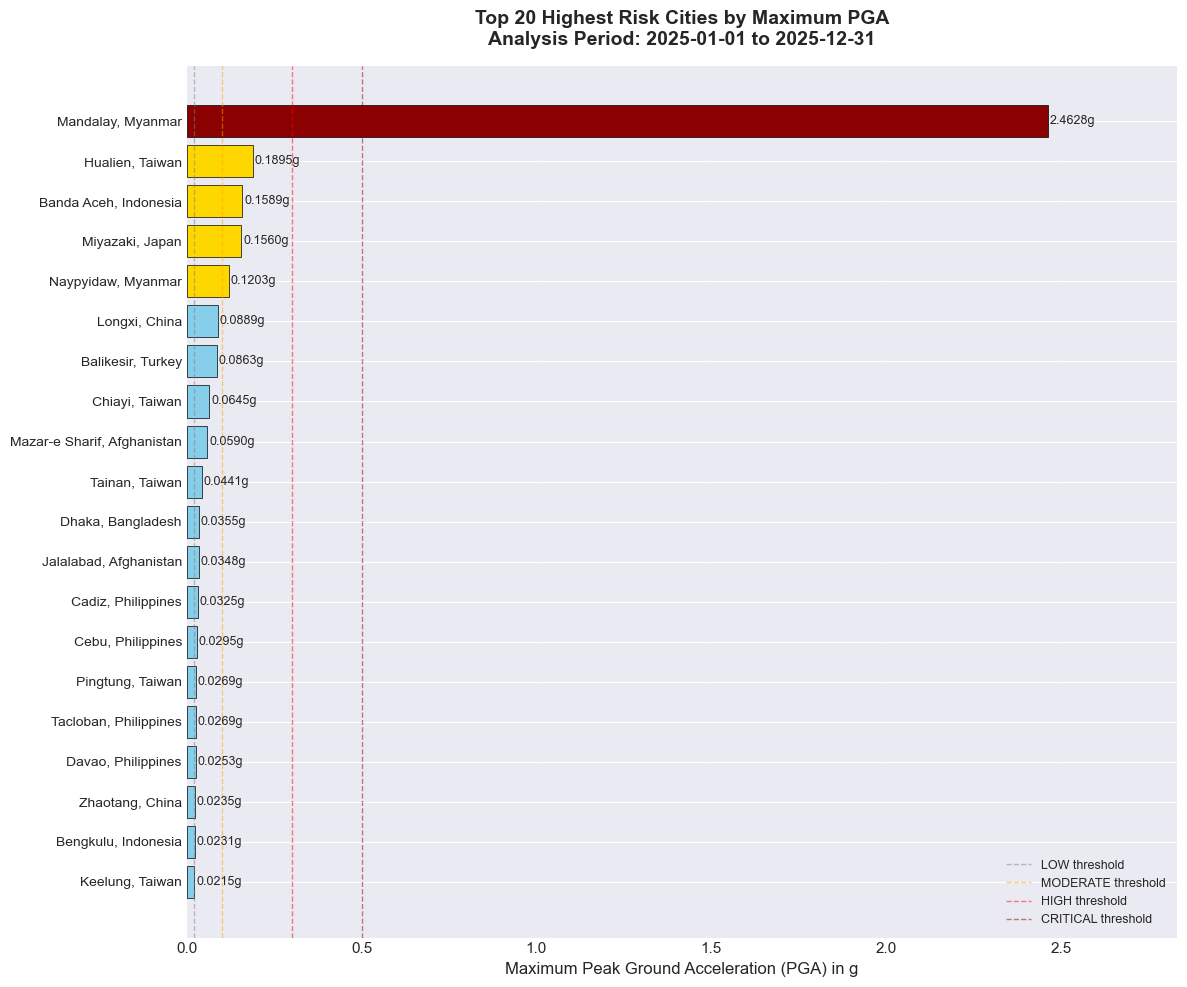

 Top cities chart created


In [11]:
# Top 20 cities by PGA (interactive)
import plotly.express as px

top20 = results_df.head(20).copy()
fig = px.bar(
    top20,
    x='max_pga',
    y='city_name',
    orientation='h',
    color='max_pga',
    color_continuous_scale='Reds',
    title='Top 20 Cities by Seismic Risk (PGA)',
    labels={'max_pga': 'Max PGA (g)', 'city_name': 'City'}
)
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    height=500,
    width=800,
    font=dict(size=14),
    title_font_size=20
)
fig.show()


### Creating PGA attenuation plot...


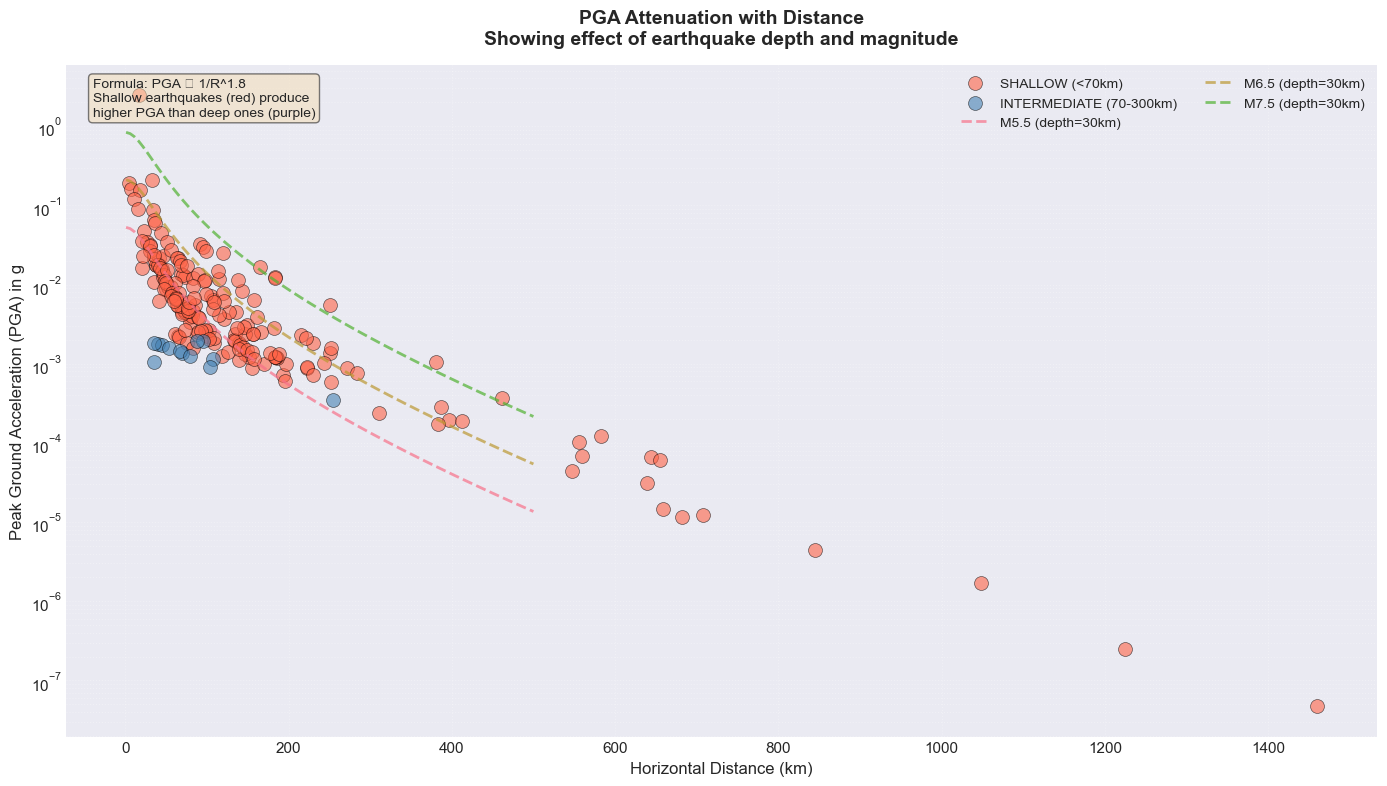

 Attenuation plot created


In [12]:
# Magnitude vs Depth scatter (interactive)
import plotly.express as px

eq_df = earthquakes.copy()

fig = px.scatter(
    eq_df,
    x='mag',
    y='depth_km',
    color='mag',
    size='mag',
    title='Earthquake Magnitude vs Depth',
    labels={'mag': 'Magnitude', 'depth_km': 'Depth (km)'},
    color_continuous_scale='Viridis',
    hover_data=['place']
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    height=500,
    width=800,
    font=dict(size=14),
    title_font_size=20
)
fig.show()


 PGA Distribution Histogram...


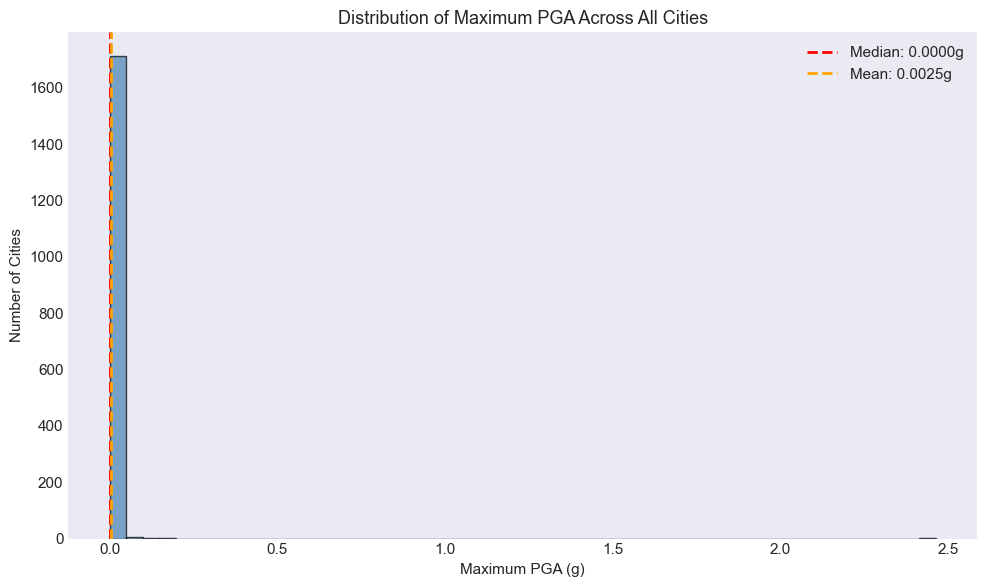

 Histogram complete


In [13]:
# PGA Distribution (interactive)
import plotly.express as px

fig = px.histogram(
    results_df[results_df['max_pga'] > 0],
    x='max_pga',
    nbins=30,
    title='Distribution of Peak Ground Acceleration Values',
    labels={'max_pga': 'Max PGA (g)', 'count': 'Number of Cities'},
    color_discrete_sequence=['steelblue']
)
fig.update_layout(
    bargap=0.1,
    height=450,
    width=800,
    font=dict(size=14),
    title_font_size=20
)
fig.show()


In [14]:
print("Risk Categories Distribution...")

# use plotly for a nicer interactive pie chart
import plotly.express as px

risk_counts = results_df["risk_category"].value_counts().reset_index()
risk_counts.columns = ["Category", "Count"]

# order by severity
category_order = ["CRITICAL", "HIGH", "MODERATE", "LOW", "MINIMAL"]
risk_counts["order"] = risk_counts["Category"].apply(lambda x: category_order.index(x) if x in category_order else 99)
risk_counts = risk_counts.sort_values("order")

# colors for each category
color_map = {
    "CRITICAL": "#8B0000",
    "HIGH": "#FF4500",
    "MODERATE": "#FFD700",
    "LOW": "#87CEEB",
    "MINIMAL": "#D3D3D3"
}

fig = px.pie(
    risk_counts,
    values="Count",
    names="Category",
    title="Distribution of Risk Categories",
    color="Category",
    color_discrete_map=color_map,
    hole=0.3  # makes it a donut chart which looks nicer
)

fig.update_traces(
    textposition="inside",
    textinfo="percent+label",
    hovertemplate="<b>%{label}</b><br>Cities: %{value}<br>Percentage: %{percent}<extra></extra>"
)

fig.update_layout(
    height=500,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5)
)

fig.show()

print("Done")


Risk Categories Distribution...


Done


In [ ]:
# PGA Attenuation with Distance
import plotly.express as px
import numpy as np
from earthquake_exposure import metrics

# Generate theoretical attenuation curves for different magnitudes
distances = np.linspace(10, 500, 100)
depth = 30  # average depth

attenuation_data = []
for mag in [5.0, 6.0, 7.0, 8.0]:
    for d in distances:
        pga = metrics.calculate_pga_gmpe(mag, d, depth)
        attenuation_data.append({'Distance (km)': d, 'PGA (g)': pga, 'Magnitude': f'M{mag}'})

import pandas as pd
attenuation_df = pd.DataFrame(attenuation_data)

fig = px.line(
    attenuation_df,
    x='Distance (km)',
    y='PGA (g)',
    color='Magnitude',
    title='PGA Attenuation with Distance (depth=30km)',
    color_discrete_sequence=['#1f77b4', '#ff7f0e', '#d62728', '#9467bd']
)
fig.update_layout(
    height=500,
    width=800,
    font=dict(size=14),
    title_font_size=20,
    yaxis_type='log'  # log scale for better visualization
)
fig.show()


In [17]:
# Create output directory
output_dir = Path('../outputs')
output_dir.mkdir(exist_ok=True)

# Export main results
output_file = output_dir / 'seismic_risk_results.csv'
results_df.to_csv(output_file, index=False)

print(f"Results exported to: {output_file}")
print(f"Total rows: {len(results_df)}")
print(f"Columns: {', '.join(results_df.columns)}")

# Also save summary statistics
summary_file = output_dir / 'summary_statistics.txt'
with open(summary_file, 'w') as f:
    f.write("-"*50 + "\n")
    f.write("SEISMIC RISK ANALYSIS - SUMMARY STATISTICS\n")
    f.write("-"*50 + "\n\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Time Period: {start_date.date()} to {end_date.date()}\n\n")
    f.write(f"Total Cities Analyzed: {len(results_df)}\n")
    f.write(f"Total Earthquakes: {len(earthquakes_raw)}\n\n")
    f.write("Risk Category Distribution:\n")
    f.write(results_df['risk_category'].value_counts().to_string())
    f.write("\n\nTop 10 Highest Risk Cities:\n")
    f.write(results_df[['city_name', 'country', 'max_pga', 'risk_category']].head(10).to_string(index=False))

print(f"Summary exported to: {summary_file}")

Results exported to: ../outputs/seismic_risk_results.csv
Total rows: 1721
Columns: city_name, country, population, max_pga, risk_category, risk_description, num_earthquakes, num_shallow_quakes, max_magnitude, closest_quake_distance, top_contributing_quakes
Summary exported to: ../outputs/summary_statistics.txt


## 5. Key Findings & Conclusions

See METHODOLOGY.md for details.


### Creating interactive geographic risk map...


In [18]:

# Get country boundaries for the map
asia_bounds = acquire.get_country_boundaries()

# Generate interactive map using our viz module
# We pass the raw (lat/lon) dataframes as Plotly handles the projection
fig = viz.generate_plotly_map(
    cities_gdf=cities_raw,
    eq_gdf=earthquakes_raw,
    exposure_df=results_df,
    boundaries_gdf=asia_bounds
)

# Display the map inline
fig.show()

# Save to HTML file
output_path = os.path.join("outputs", "interactive_risk_map.html")
if not os.path.exists("outputs"):
    os.makedirs("outputs")
    
fig.write_html(output_path)
print(f"\u2713 Interactive map saved to {output_path}")

✓ Interactive map saved to outputs/interactive_risk_map.html
